In [29]:
import itertools
import os
import zipfile
import csv
import textwrap

from pprint import pprint

import spacy
import numpy
import pandas
import umap

from headless import load_pages
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
%matplotlib inline


In [30]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import magma

output_notebook()

Loading BokehJS ...

In [31]:
en_nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])

In [55]:
N_BANDS = 50

def author_title(htid, metadata_file, id_field, author_field, title_field, csv_delim='\t'):
    with open(metadata_file, mode ='r') as file:
        csv_reader = csv.DictReader(file, delimiter=csv_delim)
        htid_table = {r[id_field]: r for r in csv_reader}
        
    htid = htid.replace('+', ':').replace('=', '/')
    if htid in htid_table:
        row = htid_table[htid]
        return row[title_field] + " " + row[author_field]
    return "could not find title and author"

def volume_paths(path):
    """List all zip files and subfolders in the given folder."""
    files = (os.path.join(path, f) for f in sorted(os.listdir(path)))
    return [f for f in files if os.path.isdir(f) or f.endswith('.zip')]

def numpy_paths(path):
    """List all numpy files in the given folder."""
    files = (os.path.join(path, f) for f in sorted(os.listdir(path)))
    return [f for f in files if f.endswith('.npy')]

def load_one_sp_embedding(volume_path):
    """Parse the text of one volume and extract word vectors."""
    sp_text = en_nlp.pipe(load_pages(volume_path))
    return numpy.array([tok.vector.reshape(-1) for doc in sp_text for tok in doc if not tok.is_space])

def piecewise_avg(vec, n_groups):
    """Divide a vector into pieces and return the average for each."""
    size = len(vec) / n_groups
    ends = []
    for i in range(1, n_groups + 1):
        ends.append(int(size * i))
    ends[-1] = len(vec)
    
    sums = []
    start = 0
    for end in ends:
        sums.append(vec[start:end].sum() / (end - start))
        start = end
        
    return numpy.array(sums)
        
def embedding_fft(sp_embedding, n_bands=N_BANDS, flatten=False):
    """
    Perform a Fourier transform on all the dimensions of an
    array of word embeddings extracted from a document. 
    `sp_embedding` is assumed to be an array with a row
    for each document, and a column for each dimension of 
    the underlying word embedding vector model.
    """
    fft_cols = []
    n_groups = 1
    while n_groups < n_bands * 10:
        n_groups *= 2
        
    for col in range(sp_embedding.shape[1]):
        vec = sp_embedding[:, col]
        vec = piecewise_avg(vec, n_groups)
        fft = numpy.fft.rfft(vec)
        fft_cols.append(fft[:n_bands])
    
    if flatten:
        return flatten_fft(fft_cols)
    else:
        return numpy.array(fft_cols)

def flatten_fft(emb_fft):
    """Reshape an fft array into a single vector."""
    complex_vec = numpy.array(emb_fft).reshape(-1)
    return numpy.array([x for r_i in zip(complex_vec.real, complex_vec.imag)
                        for x in r_i])

def unflatten_vec(doc_vector, cols=N_BANDS * 2):
    """Turn a document vector back into an fft array."""
    array = doc_vector.reshape(300, cols)  # This hard-codes values that should be parameters.
    real = array[:, ::2]
    imag = array[:, 1::2]
    return real + imag * 1j
    
def test_fft_reshape(volume_path):
    """A test of vector-array conversion routines."""
    assert _test_fft_reshape_one(volume_path)

def _test_fft_reshape_one(folder):
    emb = load_one_sp_embedding(folder)
    
    fft_orig = embedding_fft(emb, flatten=False)
    
    fft_complex = unflatten_vec(embedding_fft(emb, flatten=True))
    return (fft_orig == fft_complex).all()

def vol_path_to_npy_path(vol_path):
    return vol_path if not vol_path.endswith('.zip') else vol_path[:-4]

def save_sp_embeddings(source_path, dest_path=None):
    dest_path = source_path if dest_path is None else dest_path
    vol_paths = volume_paths(source_path)
    new_paths = [vol_path_to_npy_path(os.path.join(dest_path, os.path.split(vp)[-1]))
                 for vp in vol_paths]
    
    sp_embeddings = (load_one_sp_embedding(v) for v in vol_paths)
    for emb, np in zip(sp_embeddings, new_paths):
        numpy.save(np, emb)        

def save_embedding_ffts(source_path, dest_path=None):
    dest_path = source_path if dest_path is None else dest_path
    vol_paths = volume_paths(source_path)
    new_paths = [vol_path_to_npy_path(os.path.join(dest_path, os.path.split(vp)[-1]))
                 for vp in vol_paths]
    
    sp_embeddings = (load_one_sp_embedding(v) for v in vol_paths)
    emb_ffts = (embedding_fft(e) for e in sp_embeddings)
    for emb, np in zip(emb_ffts, new_paths):
        numpy.save(np, emb) 

def load_embedding_fft_array(path):
    return numpy.array([flatten_fft(numpy.load(f)) for f in numpy_paths(path)])

def load_embedding_fft_metadata(metadata_path, fft_path, csv_delim='\t', htid_col='htid'):
    ids = [os.path.split(p)[-1][:-4].replace('+', ':').replace('=', '/')
           for p in numpy_paths(fft_path)]
    metadata = pandas.read_csv(metadata_path, index_col=htid_col, delimiter=csv_delim)
    return metadata.reindex(ids, fill_value='[metadata missing]')

def load_embedding_ffts(path, flatten=True):
    if flatten:
        return {os.path.split(f)[-1][:-4]: flatten_fft(numpy.load(f)) 
                for f in numpy_paths(path)}
    else:
        return {os.path.split(f)[-1][:-4]: numpy.load(f)
                for f in numpy_paths(path)}

def show_dataset(folder, n=10):
    volumes = volume_paths(folder)
    for v in volumes:
        print(load_pages(v)[0][0:500])

def show_umap(data, n_neighbors=20, min_dist=0.001, metric='euclidean'):
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    vis = um.fit_transform(data)
    plt.gca().axis('equal')
    plt.scatter(vis[:, 0], 
                vis[:, 1], 
                c=[i / len(vis) for i in range(len(vis))],
                cmap='plasma')
    plt.show()

def show_umap_bokeh(data, metadata, n_neighbors=20, min_dist=0.001, metric='euclidean'):
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    vis = um.fit_transform(data)
    magma_palette = magma(10)
    color = [i / len(vis) for i in range(len(vis))]
    color = [magma_palette[int(c * 10)] for c in color]
    scatter_data = pandas.DataFrame({'umap_1': vis[:, 0], 
                                     'umap_2': vis[:, 1],
                                     'color': color,
                                     'title': ['<br>'.join(textwrap.wrap(t)) 
                                               for t in metadata['title']],
    })
    
    plot_figure = figure(
        title='UMAP Projection of Phasor vectors for ~1000 random HathiTrust volumes',
        plot_width=600,
        plot_height=600,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(HoverTool(
        tooltips="<span style='font-size: 10px'>@title{safe}</span>"
    ))

    plot_figure.circle(
        'umap_1',
        'umap_2',
        color='color',
        source=scatter_data,
    )

    show(plot_figure)
    
def htid_url(htid):
    htid = htid.replace('+', ':').replace('=', '/')
    return 'https://babel.hathitrust.org/cgi/pt?id={}'.format(htid)

In [33]:
# path_to_volumes = '/media/secure_volume/workset/orig'
# path_to_fft = '../media/secure_volume/workset/npy_fft'
# path_to_meta = 
path_to_volumes = '../ht-open-test-data/gov_docs/'
path_to_fft = '../ht-open-test-data/gov_docs_fft'
path_to_meta = '../ht-open-test-data/gov_docs_fakemeta.csv'
# path_to_volumes = '../ht-open-test-data/fiction_998/'
# path_to_fft = '../ht-open-test-data/fiction_fft'

In [5]:
for test_path in volume_paths(path_to_volumes)[:3]:
    print('testing with {}'.format(test_path))
    try:
        test_fft_reshape(test_path)
    except Exception as e:
        print('skipping {} -- {}: {}'.format(test_path, type(e), e))

testing with ../ht-open-test-data/gov_docs/0314624,0001,001.zip
testing with ../ht-open-test-data/gov_docs/0962976,1912,001.zip
testing with ../ht-open-test-data/gov_docs/0962976,1912,002.zip


In [6]:
# save_embedding_ffts(path_to_volumes, path_to_fft)

In [54]:
show_umap_bokeh(
    load_embedding_fft_array(path_to_fft),
    load_embedding_fft_metadata(path_to_meta, path_to_fft)
)

In [23]:
data_dict = load_embedding_ffts(path_to_fft)
data = list(data_dict.items())
files, data = zip(*data)
data_umap = umap.UMAP(n_neighbors=5, n_components=10, metric='euclidean').fit_transform(data)

/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [24]:
data_umap.shape

(998, 10)

In [25]:
data_umap_kd = KDTree(data_umap)

In [26]:
pairs = list(data_umap_kd.query_pairs(0.010))
pairs

[(738, 967),
 (645, 774),
 (750, 967),
 (645, 981),
 (738, 750),
 (706, 796),
 (678, 774),
 (240, 798),
 (15, 104),
 (20, 70),
 (717, 744),
 (309, 750),
 (265, 891),
 (645, 869),
 (312, 914),
 (21, 23),
 (309, 738),
 (774, 981),
 (202, 983),
 (309, 967),
 (678, 869),
 (645, 678),
 (109, 110),
 (678, 981),
 (692, 811),
 (356, 375),
 (869, 981),
 (774, 869)]

In [27]:
pair_ids = [(files[x], files[y]) for x, y in pairs]
distances = [((data_umap[x] - data_umap[y]) ** 2).sum() ** 0.5 for x, y in pairs]
for (a, b), d in zip(pair_ids, distances):
    print()
    print()
    print('10-D UMAP Distance: ', d)
    print(htid_url(a))
    print(author_title(a, path_to_meta, 'htid', 'author', 'title'))
    print(htid_url(b))
    print(author_title(b, path_to_meta, 'htid', 'author', 'title'))
    print()
    print('------')
    



10-D UMAP Distance:  6.799220729487844e-05
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t6rx9bj9n
Fake Title Fake Author
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t9r21cx38
Fake Title Fake Author

------


10-D UMAP Distance:  5.95360599749367e-06
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t5gb2ph16
Fake Title Fake Author
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t78s59w3v
Fake Title Fake Author

------


10-D UMAP Distance:  4.015350906306078e-05
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t71v5kt29
Fake Title Fake Author
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t9r21cx38
Fake Title Fake Author

------


10-D UMAP Distance:  1.5645509658344612e-06
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t5gb2ph16
Fake Title Fake Author
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t9t15kx9f
Fake Title Fake Author

------


10-D UMAP Distance:  5.103015077322007e-05
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t6rx9bj9n
Fake Title Fake Aut

In [13]:
# for a, b in pair_ids:
#     diff = data_dict[a] - data_dict[b]
#     plt.plot(diff)
#     plt.show()

In [14]:
# dist between 10 smallest pairs in base space
pair_dists = numpy.array([((data[x] - data[y]) ** 2).sum() ** 0.5 
                          for x, y in pairs])
smallest_ix = pair_dists.argsort()[:10]
print("closest pairs in base space")
pprint(list(zip([pairs[i] for i in smallest_ix], pair_dists[smallest_ix])))

# dist between pairs in umap space
pair_umap_dists = numpy.array([((data_umap[x] - data_umap[y]) ** 2).sum() ** 0.5
                               for x, y in pairs])
smallest_ix = pair_umap_dists.argsort()[:10]
print("closest pairs in umap space")
pprint(list(zip([pairs[i] for i in smallest_ix], pair_umap_dists[smallest_ix])))

closest pairs in base space
[((474, 843), 27.11835838759191),
 ((309, 750), 54.06577270209865),
 ((738, 750), 55.143650296446964),
 ((806, 849), 56.5459512308267),
 ((309, 738), 57.31296558677058),
 ((691, 986), 79.59228133166052),
 ((738, 967), 80.88914686994127),
 ((309, 967), 102.71330451263222),
 ((42, 43), 119.21707405062106),
 ((678, 774), 120.58887385435808)]
closest pairs in umap space
[((750, 967), 3.174786725334782e-06),
 ((309, 738), 4.539403421844412e-06),
 ((738, 750), 9.565872357356383e-06),
 ((738, 967), 1.2566909996155945e-05),
 ((309, 750), 1.3312067257019414e-05),
 ((309, 967), 1.63878971104114e-05),
 ((678, 774), 0.003977333694567807),
 ((312, 914), 0.004522140190301693),
 ((42, 43), 0.005411340349053365),
 ((317, 665), 0.0056153898632249075)]


In [15]:
data_freq_array = [unflatten_vec(r) / len(data) for r in data]  # 300 rows, 20 cols in each array, ~1000 arrays

data_freq_mean = data_freq_array[0]
for dfa in data_freq_array[1:]:
    data_freq_mean += dfa

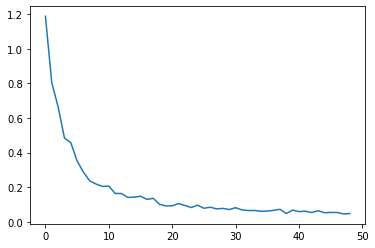

In [16]:
power_a = data_freq_mean[:, 1:].real
power_b = data_freq_mean[:, 1:].imag
power = (power_a * power_a + power_b * power_b) ** 0.5

mean_power = power.sum(axis=0) / 300
plt.plot(mean_power)

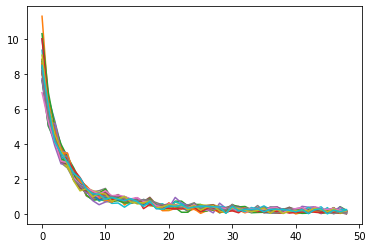

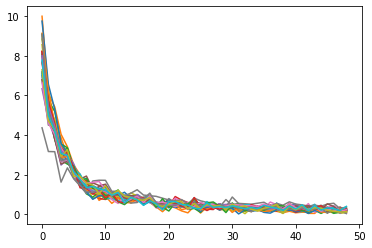

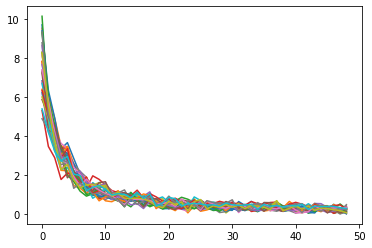

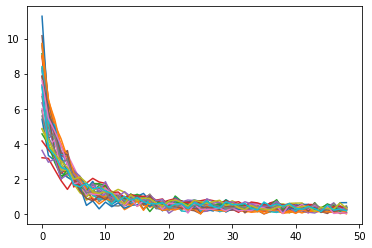

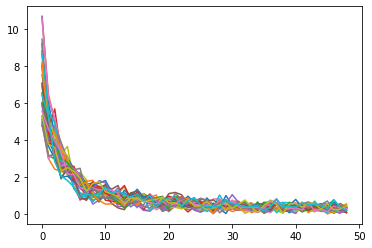

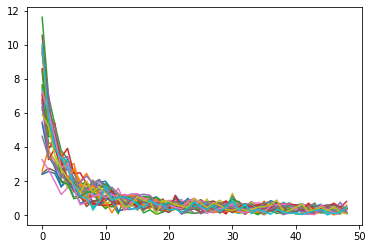

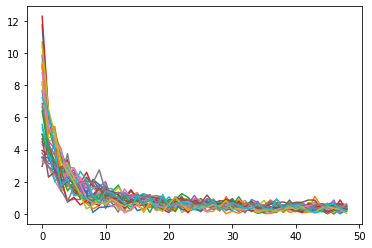

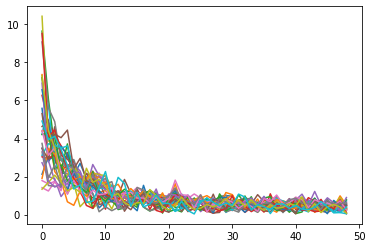

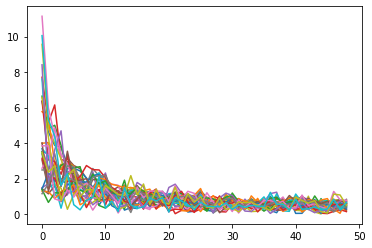

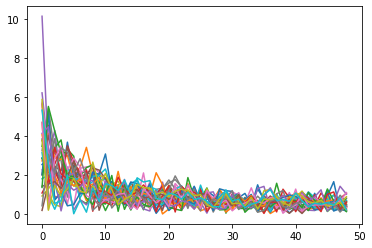

In [17]:
scaled_mean = mean_power / mean_power.mean()
scaled_power = power / power.mean(axis=0)
# scaled_rel_diff = []

scaled_diffs = numpy.array([(((scaled_power[i] - scaled_mean) / scaled_power[i]) ** 2).sum()
                            for i in range(len(power))])

scaled_diffs_argsort = scaled_diffs.argsort()

for chunk in range(10):
    for i in range(chunk * 30, chunk * 30 + 30):
        plt.plot(power[scaled_diffs_argsort[i]] / 
                 power[scaled_diffs_argsort[i]].mean())
    plt.show()